In [76]:
#Generellt användbara bibliotek
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

#Transformers bibliotek relaterade till BERT
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

Limit the data to the first 1000 reviews, seeing that I only want to practice a sentiment analysis approach 

In [77]:
data = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')
sampeled_data = data[:2000]
sampeled_data_training = data[2000:4000]
sampeled_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Initialize the tokenizer and the model. For this sentiment analysis I will be using the roBERTa transformer model to perform the analysis.  

In [6]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Define a function that takes in a reviews-list and a index for retreving a single review. The function should:

    - Retrieve the review that is stored at the index.
    - Tokenize the review with the previously defined tokenizer that is associated with the model. 
    - Feed the tokenized review to the model.
    - Apply the softmax function to the result, which will then return our polarity scores.
    - Assign the polarity scores to integers. 
    - Use the polarity scores integers to calculate a rough score between 1-5 (I arrived at this way of calculating score beeing the best, seeing            that this go the least amount of 'wrong' scores compared to the actual scores left by the user and also being able to caluclate the entire range of 1 - 5).
    - Return a dictionary that contains the:
        1. Negative score
        2. Neutral score
        3. Positive score
        4. Calculated score

In [103]:
def calcPolarityScores(reviews, index):
    sample_review = reviews[index]
    input = tokenizer(sample_review, padding=True, truncation=True, max_length=128, return_tensors="pt")
    result = model(**input)
    polarity_scores = softmax(result[0][0].detach().numpy())
    neg, neu, pos = polarity_scores
    review_score = round(neg*1 + neu*3 + pos*5)
    result_dictionary = {
        "Negative" : neg,
        "Neutral" : neu,
        "Positive" : pos,
        "Calculated score" : review_score,
    }
    return result_dictionary
    

Apply the function to all 1000 reviews in the dataset and store the resulting dictionary for each review in a list called polarity_scores.

In [104]:
polarity_scores = []
for idx, review in sampeled_data.iterrows():
    result = calcPolarityScores(sampeled_data['Text'], idx)
    polarity_scores.append(result)

,Negative,Neutral,Positive,Calculated score
0,0.009624,0.049980,0.940395,5
1,0.508986,0.452414,0.038600,2
2,0.003229,0.098067,0.898704,5
3,0.002295,0.090219,0.907486,5
4,0.001635,0.010302,0.988063,5
...,...,...,...,...
1995,0.006968,0.030950,0.962082,5
1996,0.365191,0.428523,0.206286,3
1997,0.081018,0.194872,0.724110,4
1998,0.029067,0.119563,0.851370,5


In [79]:
sampeled_data_training = sampeled_data_training.reset_index(drop=True)
polarity_scores_training = []
for idx, review in sampeled_data_training.iterrows():
    result = calcPolarityScores(sampeled_data_training['Text'], idx)
    polarity_scores_training.append(result)

Convert the contents of the polarity_scores list to a dataframe.

In [108]:
polarity_scores_training_df = pd.DataFrame(polarity_scores_training)
polarity_scores_df = pd.DataFrame(polarity_scores)

Perform a right-join with our polarity_scores dataframe and our original dataframe that contained the first 1000 reviews.

In [ ]:
sampeled_data = sampeled_data.join(polarity_scores_df, how = 'right')

In [180]:
polarity_scores_training_df

,Negative,Neutral,Positive,Calculated score,Score
0,0.002375,0.007240,0.990385,5,5
1,0.001634,0.009678,0.988688,5,4
2,0.001568,0.005631,0.992801,5,5
3,0.007201,0.478775,0.514024,4,5
4,0.003188,0.011013,0.985799,5,5
...,...,...,...,...,...
1995,0.001142,0.014819,0.984039,5,4
1996,0.001476,0.021041,0.977483,5,5
1997,0.009439,0.058081,0.932480,5,4
1998,0.015377,0.047125,0.937498,5,4


In [134]:
X = polarity_scores_training_df[['Negative','Neutral','Positive']]
y = polarity_scores_training_df['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)
print("Success")

Success


In [135]:
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)
print("Training success")

Training success


In [136]:
y_train_pred = regressor.predict(X_train_scaled).clip(1, 5)
y_test_pred = regressor.predict(X_test_scaled).clip(1, 5)
print("Success")

Success


In [138]:
# y_prediction = regressor.predict(X_test_scaled)
meanAbsErr = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"The mean absolute error: {meanAbsErr}")
print(f"The R² score: {r2}")
print("Success")

The mean absolute error: 0.6065127602219582
The R² score: 0.5408532498169863
Success


In [143]:
X_actual = sampeled_data[['Negative','Neutral','Positive']]
print("Success")

Success


In [144]:
X_actual_scaled = scaler.transform(X_actual) 
print("Success")

Success


In [150]:
predicted_scores = regressor.predict(X_actual_scaled).clip(1, 5)  # Clip predictions to the 1-5 range
print("Success")

Success


In [164]:
sampeled_data['Predicted_Score'] = predicted_scores

In [166]:
predicted_list = sampeled_data['Predicted_Score']
predicted_rounded_list = []
for i in predicted_list:
    predicted_rounded_list.append(round(i))

In [159]:
print(sampeled_data.describe())

                Id  HelpfulnessNumerator  HelpfulnessDenominator        Score  \
count  2000.000000           2000.000000             2000.000000  2000.000000   
mean   1000.500000              1.448000                1.859000     4.200500   
std     577.494589              5.280174                5.936644     1.303898   
min       1.000000              0.000000                0.000000     1.000000   
25%     500.750000              0.000000                0.000000     4.000000   
50%    1000.500000              0.000000                0.000000     5.000000   
75%    1500.250000              1.000000                2.000000     5.000000   
max    2000.000000            165.000000              168.000000     5.000000   

               Time  Predicted_Score     Negative      Neutral     Positive  \
count  2.000000e+03      2000.000000  2000.000000  2000.000000  2000.000000   
mean   1.291112e+09         4.173643     0.148615     0.121040     0.730345   
std    5.007583e+07         1.050

In [160]:
print(sampeled_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      2000 non-null   int64  
 1   ProductId               2000 non-null   object 
 2   UserId                  2000 non-null   object 
 3   ProfileName             2000 non-null   object 
 4   HelpfulnessNumerator    2000 non-null   int64  
 5   HelpfulnessDenominator  2000 non-null   int64  
 6   Score                   2000 non-null   int64  
 7   Time                    2000 non-null   int64  
 8   Summary                 2000 non-null   object 
 9   Text                    2000 non-null   object 
 10  Predicted_Score         2000 non-null   float32
 11  Negative                2000 non-null   float32
 12  Neutral                 2000 non-null   float32
 13  Positive                2000 non-null   float32
 14  Calculated_score        2000 non-null   

In [161]:
print(sampeled_data['Score'].value_counts())

Score
5    1303
4     254
1     178
3     162
2     103
Name: count, dtype: int64


Lets do some data vizualisation! I am curious if the linear regression model was actually accurate and if it could beat my own way of calculating the score. So lets make 4 histograms for the following categories: 

    - The distribution of the actual scores
    - The predicted scores (unrounded)
    - The predicted scores (rounded)
    - The calculated scores
    

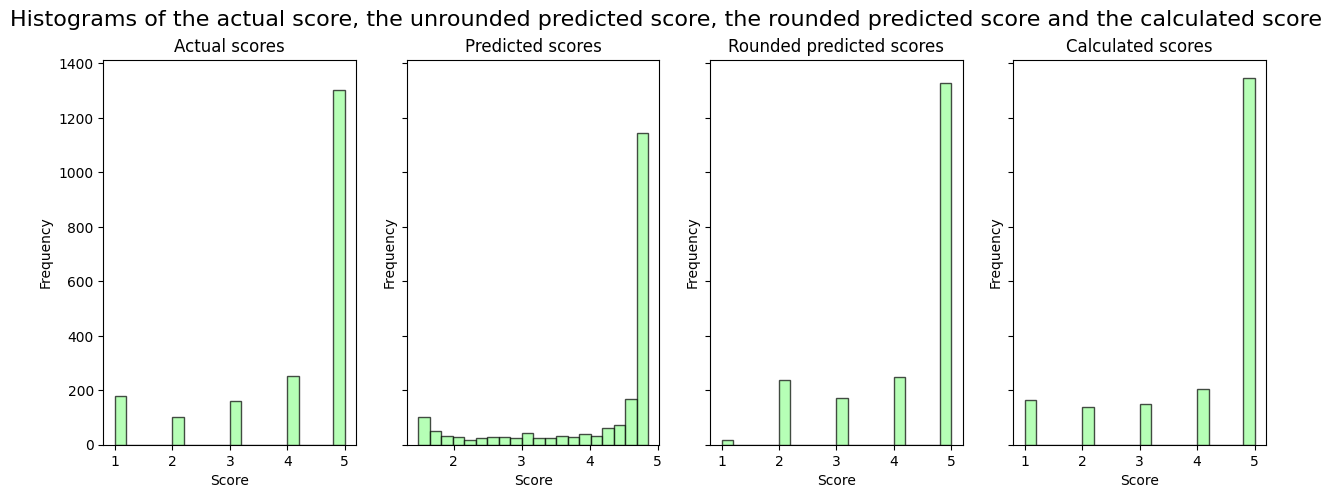

In [178]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)  # 1 row, as many columns as needed
fig.suptitle("Histograms of the actual score, the unrounded predicted score, the rounded predicted score and the calculated score", fontsize = 16)

axes[0].hist(sampeled_data['Score'], bins = 20, color = '#98FF98', alpha = 0.7, edgecolor = 'black')
axes[0].set_title("Actual scores")
axes[0].set_xlabel("Score")
axes[0].set_ylabel("Frequency")

axes[1].hist(sampeled_data['Predicted_Score'], bins = 20, color = '#98FF98', alpha = 0.7, edgecolor = 'black')
axes[1].set_title("Predicted scores")
axes[1].set_xlabel("Score")
axes[1].set_ylabel("Frequency")

axes[2].hist(predicted_rounded_list, bins = 20, color = '#98FF98', alpha = 0.7, edgecolor = 'black')
axes[2].set_title("Rounded predicted scores")
axes[2].set_xlabel("Score")
axes[2].set_ylabel("Frequency")

axes[3].hist(sampeled_data['Calculated_score'], bins = 20, color = '#98FF98', alpha = 0.7, edgecolor = 'black')
axes[3].set_title("Calculated scores")
axes[3].set_xlabel("Score")
axes[3].set_ylabel("Frequency")


plt.show()

Make histograms depicting the distribution of the different polarity scores and also the distribution of the calculated scores.

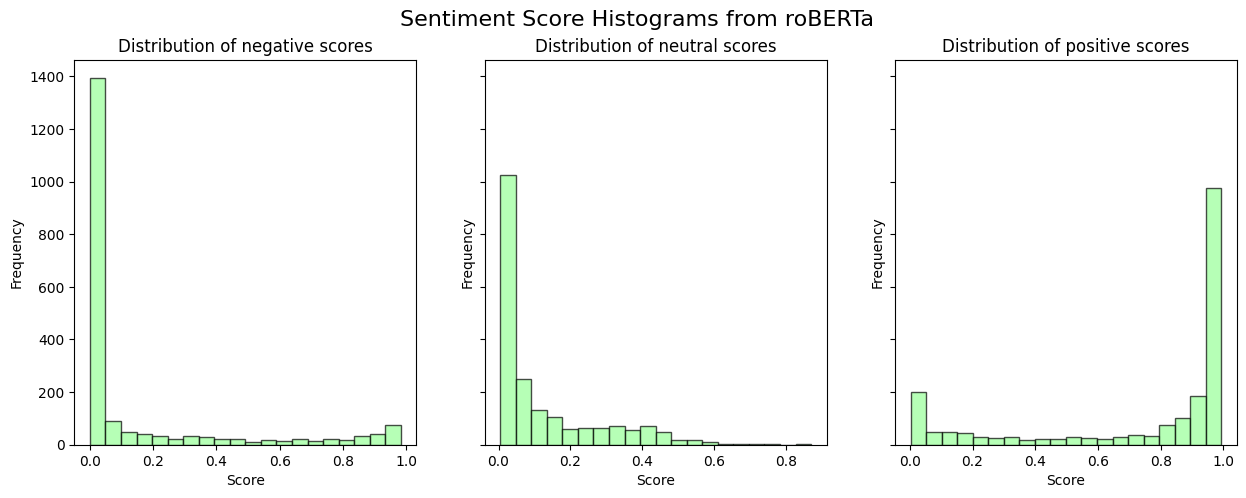

In [177]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  # 1 row, as many columns as needed
fig.suptitle("Sentiment Score Histograms from roBERTa", fontsize = 16)
axes[0].hist(sampeled_data['Negative'], bins = 20, color = '#98FF98', alpha = 0.7, edgecolor = 'black')
axes[0].set_title("Distribution of negative scores")
axes[0].set_xlabel("Score")
axes[0].set_ylabel("Frequency")

axes[1].hist(sampeled_data['Neutral'], bins = 20, color = '#98FF98', alpha = 0.7, edgecolor = 'black')
axes[1].set_title("Distribution of neutral scores")
axes[1].set_xlabel("Score")
axes[1].set_ylabel("Frequency")


axes[2].hist(sampeled_data['Positive'], bins = 20, color = '#98FF98', alpha = 0.7, edgecolor = 'black')
axes[2].set_title("Distribution of positive scores")
axes[2].set_xlabel("Score")
axes[2].set_ylabel("Frequency")

plt.show()